In [ ]:
#Import Required Libraries
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is split into train_df, val_df, and test_df to separate the data into training, validation, and test sets. These DataFrames contain the metadata (e.g., file paths and labels) needed for loading the images and their corresponding labels.

The custom data generators (train_generator_main, validation_generator_main, and test_generator_main) are functions that take the metadata (in the form of DataFrames) and batch size as input. They yield batches of preprocessed images and their corresponding labels, which can be directly used as input by the model during training and evaluation.

This code first generates NumPy arrays for training, validation, and testing data by calling the generate_numpy_arrays function on the respective reduced dataframes. Then, it saves these NumPy arrays to Google Drive, creating separate files for the data and labels of each dataset. After saving the NumPy arrays, it loads them back from Google Drive and creates custom data generators using the array_data_generator function.

 This function takes the data and labels arrays along with the batch size as input and yields batches of shuffled data and labels on each iteration. The code finally creates train_generator, validation_generator, and test_generator using this function, which can be used to feed data in batches to a neural network during training, validation, and testing.

In [ ]:
# Load the NumPy arrays from Google Drive
train_data = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/train_data.npy')
train_labels = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/train_labels.npy')

val_data = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/val_data.npy')
val_labels = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/val_labels.npy')

test_data = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/test_data.npy')
test_labels = np.load('/content/drive/MyDrive/DeepLearningProject/GeneratedData5p/test_labels.npy')

# Define the array_data_generator function
def array_data_generator(data, labels, batch_size):
    num_samples = len(data)  # Get the total number of samples in the data array
    while True:
        # Shuffle the data and labels using the same permutation
        idx = np.random.permutation(num_samples)
        data = data[idx]
        labels = labels[idx]
        
        # Calculate the number of batches based on the batch size
        num_batches = num_samples // batch_size

        # Iterate through the data and labels arrays in chunks of the given batch_size
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size  # Calculate the starting index for the current batch
            end_idx = (batch_idx + 1) * batch_size  # Calculate the ending index for the current batch

            # Yield a batch of data and labels using the start and end indices
            yield data[start_idx:end_idx], labels[start_idx:end_idx]

# Set the batch size for the data generators
batch_size = 128
# Create data generators for train, validation, and test data using the array_data_generator function
train_generator = array_data_generator(train_data, train_labels, batch_size)
validation_generator = array_data_generator(val_data, val_labels, batch_size)
test_generator = array_data_generator(test_data, test_labels, batch_size)


This code loads the saved NumPy arrays of train, validation, and test data and labels from Google Drive. Then, it defines the array_data_generator function, which takes the data, labels, and batch size as input parameters. Inside the function, it calculates the total number of samples and the number of batches based on the given batch size. It uses a while True loop to continuously shuffle the data and labels and iterate through them in chunks of the given batch size. On each iteration, the function yields a batch of data and labels for the neural network to process. Finally, the code sets the batch size and creates train_generator, validation_generator, and test_generator using the array_data_generator function for train, validation, and test datasets, respectively

In [ ]:
def create_model(model_name, num_classes, input_shape=(224, 224, 3)):
    # Choose the base model based on the provided model name
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid model name")

    # Add custom classification head to the base model
    x = base_model.output  # Get the output of the base model
    x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce spatial dimensions
    x = Dense(512, activation='relu')(x)  # Add a dense layer with 512 units and ReLU activation
    x = Dropout(0.5)(x)  # Apply dropout to prevent overfitting (with a rate of 50%)
    predictions = Dense(num_classes, activation='softmax')(x)  # Add a dense layer for class predictions using softmax activation

    # Combine the base model and custom layers into a final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze pre-trained layers to prevent them from updating during training
    for layer in base_model.layers:
        layer.trainable = False

    return model

This function create_model creates a deep learning model by selecting a base model (VGG16, ResNet50, or InceptionV3) with pre-trained weights from ImageNet, and then adds custom classification layers on top of it. The function takes three arguments: model_name, num_classes, and input_shape. Based on the model_name, it initializes the chosen base model without the top layers (the classification head). Then, it adds custom layers to create a new classification head, consisting of global average pooling, a dense layer with 512 units and ReLU activation, a dropout layer with a 50% rate, and finally a dense layer with num_classes units and softmax activation for class predictions. The custom layers are combined with the base model to create the final model. Lastly, the function freezes the pre-trained layers of the base model to prevent them from updating during training, which allows the custom layers to learn from the features extracted by the base model. The final model is returned by the function.

From the Data Generator Code saved at the GeneratedData70p folder in Drive :

Number of reduced training samples: 16369

Number of reduced validation samples: 3638

Number of reduced test samples: 9094



In [ ]:
def train_evaluate_model(model_name, train_generator, validation_generator, test_generator,num_classes, epochs):
    print(f"Training {model_name} model...")

    len_train_df = 16369
    len_val_df = 3638
    len_test_df = 9094

    

    # Create the model with the specified base architecture
    model = create_model(model_name, num_classes)

    # Compile the model with appropriate optimizer, loss function, and metric
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Configure early stopping callback 
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Calculate the number of steps per epoch for both training and validation
    train_steps_per_epoch = len_train_df // batch_size
    val_steps_per_epoch = len_val_df // batch_size

    # Train the model using the specified generators and steps per epoch for training and validation
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps_per_epoch,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Check if early stopping was activated
    if early_stopping.stopped_epoch > 0:
      print("Early stopping was activated. \n")

    # Evaluating the model
    print("Evaluating the model... \n")

    # Initialize lists to store true labels and predicted labels
    y_true = []
    y_pred = []

    # Define the number of batches in the validation set
    evaluation_steps = len_test_df // batch_size

    # Iterate through the validation set
    for i in range(evaluation_steps):
        # Get the next batch of data and labels
        batch_data, batch_labels = next(test_generator)

        # Store true labels
        y_true.extend(np.argmax(batch_labels, axis=-1))

        # Make predictions for the current batch and store predicted labels
        batch_pred = model.predict(batch_data)
        y_pred.extend(np.argmax(batch_pred, axis=-1))

    # Transform the true labels and predicted labels into class names using the label_encoder
    class_names = label_encoder.inverse_transform(range(num_classes))
    y_true = label_encoder.inverse_transform(y_true)
    y_pred = label_encoder.inverse_transform(y_pred)

    # Convert class names to strings to avoid the "TypeError: object of type 'numpy.int64' has no len()" issue
    class_names = [str(cn) for cn in class_names]

    print(" The Classification Report of the Model is as Follows: \n")

    # Print the classification report (precision, recall, F1-score)
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


    # Calculate the validation accuracy
    validation_accuracy = np.mean(np.array(y_true) == np.array(y_pred))

    # Print the validation accuracy
    print(f"Validation accuracy: {validation_accuracy * 100:.2f}%")

    return validation_accuracy, history




This function train_evaluate_model trains and evaluates a deep learning model. It takes as arguments the model_name, train_generator, validation_generator, test_generator,num_classes, and epochs. The function first creates a model with the specified base architecture using the create_model function. 

It then compiles the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric. It sets up an early stopping callback to stop training when the validation loss stops improving, with a patience of 5 epochs. The function calculates the number of steps per epoch for both training and validation sets, then trains the model using the specified generators and steps per epoch.

 After training, it evaluates the model by iterating through the test set, storing true labels and predicted labels. It then prints a classification report with precision, recall, and F1-score, calculates the validation accuracy, and returns it along with the training history.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(model_name, history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

Training VGG16 model...


Epoch 1/100
1790/1790 [==============================] - 219s 115ms/step - loss: 1.9494 - accuracy: 0.2871 - val_loss: 1.9370 - val_accuracy: 0.2754
Epoch 2/100
1790/1790 [==============================] - 197s 110ms/step - loss: 1.9040 - accuracy: 0.3038 - val_loss: 1.9419 - val_accuracy: 0.2799
Epoch 3/100
1790/1790 [==============================] - 195s 109ms/step - loss: 1.8609 - accuracy: 0.3189 - val_loss: 1.9549 - val_accuracy: 0.2758
Epoch 4/100
1790/1790 [==============================] - 195s 109ms/step - loss: 1.8103 - accuracy: 0.3379 - val_loss: 1.9694 - val_accuracy: 0.2780
Epoch 5/100
1790/1790 [==============================] - 195s 109ms/step - loss: 1.7574 - accuracy: 0.3574 - val_loss: 1.9850 - val_accuracy: 0.2799
Epoch 6/100
1790/1790 [==============================] - 195s 109ms/step - loss: 1.7003 - accuracy: 0.3768 - val_loss: 2.0322 - val_accuracy: 0.2769
Epoch 7/100
1790/1790 [==============================] - 196s 109ms/step - loss: 1.6418 - accuracy: 0.3985

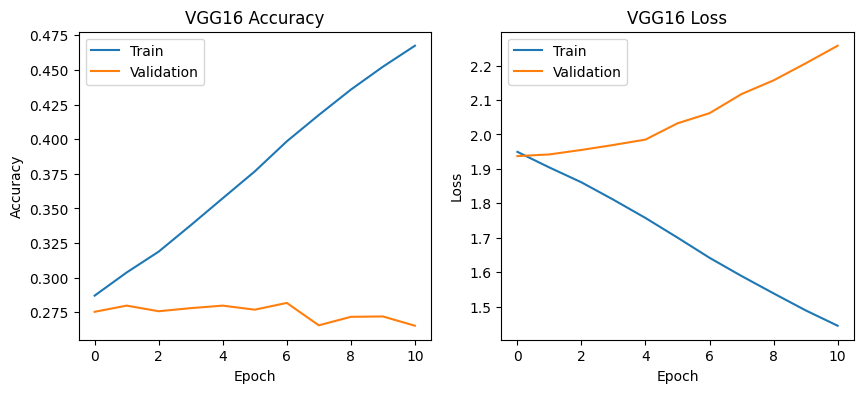

Training ResNet50 model...


Epoch 1/100
1790/1790 [==============================] - 188s 102ms/step - loss: 2.0117 - accuracy: 0.2756 - val_loss: 1.9975 - val_accuracy: 0.2648
Epoch 2/100
1790/1790 [==============================] - 177s 99ms/step - loss: 1.9981 - accuracy: 0.2779 - val_loss: 1.9983 - val_accuracy: 0.2637
Epoch 3/100
1790/1790 [==============================] - 173s 96ms/step - loss: 1.9895 - accuracy: 0.2792 - val_loss: 1.9942 - val_accuracy: 0.2659
Epoch 4/100
1790/1790 [==============================] - 173s 96ms/step - loss: 1.9862 - accuracy: 0.2803 - val_loss: 2.0081 - val_accuracy: 0.2634
Epoch 5/100
1790/1790 [==============================] - 173s 97ms/step - loss: 1.9821 - accuracy: 0.2814 - val_loss: 1.9990 - val_accuracy: 0.2637
Epoch 6/100
1790/1790 [==============================] - 173s 97ms/step - loss: 1.9800 - accuracy: 0.2826 - val_loss: 2.0136 - val_accuracy: 0.2589
Epoch 7/100
1790/1790 [==============================] - 173s 96ms/step - loss: 1.9777 - accuracy: 0.2834 - val

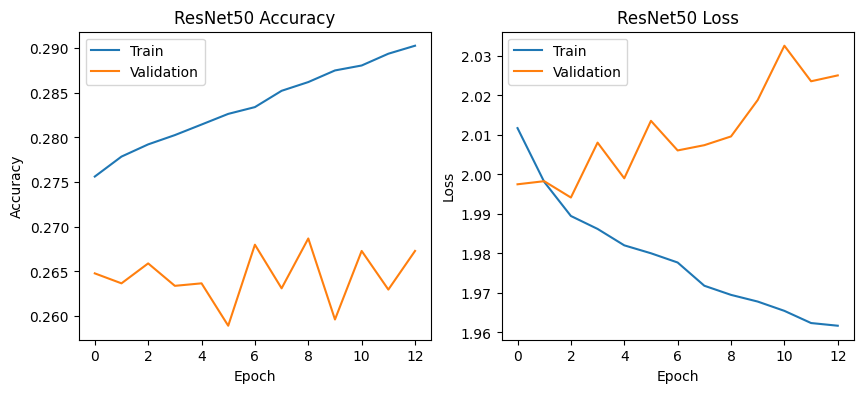

Training InceptionV3 model...
87910968/87910968 [==============================] - 5s 0us/step


Epoch 1/100
1790/1790 [==============================] - 167s 89ms/step - loss: 1.9328 - accuracy: 0.2889 - val_loss: 1.9315 - val_accuracy: 0.2969
Epoch 2/100
1790/1790 [==============================] - 157s 88ms/step - loss: 1.8139 - accuracy: 0.3244 - val_loss: 1.9774 - val_accuracy: 0.2779
Epoch 3/100
1790/1790 [==============================] - 147s 82ms/step - loss: 1.6888 - accuracy: 0.3609 - val_loss: 2.1278 - val_accuracy: 0.2786
Epoch 4/100
1790/1790 [==============================] - 142s 80ms/step - loss: 1.5773 - accuracy: 0.3904 - val_loss: 2.1807 - val_accuracy: 0.2747
Epoch 5/100
1790/1790 [==============================] - 140s 78ms/step - loss: 1.4813 - accuracy: 0.4154 - val_loss: 2.3810 - val_accuracy: 0.2546
Epoch 6/100
1790/1790 [==============================] - 138s 77ms/step - loss: 1.4070 - accuracy: 0.4351 - val_loss: 2.5105 - val_accuracy: 0.2676
Epoch 7/100
1790/1790 [==============================] - 138s 77ms/step - loss: 1.3439 - accuracy: 0.4512 - val_

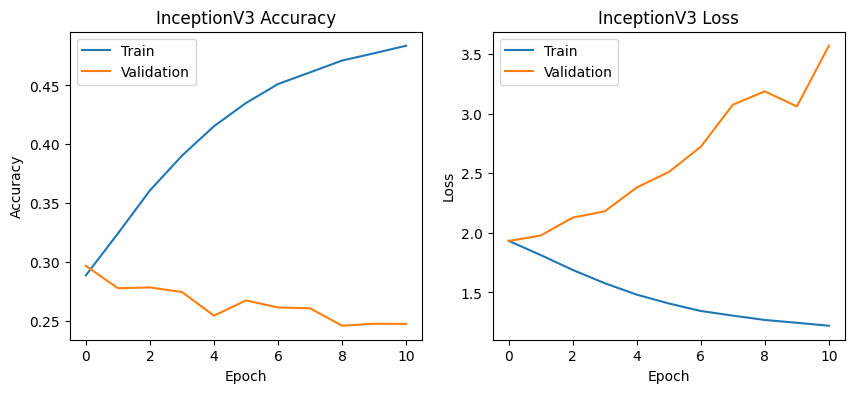

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Train and evaluate models
model_names = ['VGG16', 'ResNet50', 'InceptionV3']

best_model_name = None
best_accuracy = 0

#Define Label Encoder to find the number of classes
label_encoder = LabelEncoder()
train_labels_encoded = np.argmax(train_labels, axis=1)
label_encoder.fit(train_labels_encoded)

# Define the number of classes
num_classes = train_labels.shape[1]

#Define the Number of Epochs
epochs = 100

# Iterate through the list of model names
for model_name in model_names:
    # Train and evaluate the current model
    accuracy, history = train_evaluate_model(model_name, train_generator, validation_generator, test_generator, num_classes, epochs)

    # Plot training and validation accuracy and loss
    plot_history(model_name, history)

    # Update the best model and accuracy if the current model has better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name



This code snippet trains and evaluates three deep learning models ('VGG16', 'ResNet50', 'InceptionV3') using the provided train and validation generators. It defines the number of classes, sets the number of epochs to 20, and initializes variables to keep track of the best model and its accuracy. 

It then iterates through the list of model names, training and evaluating each model with the train_evaluate_model function. After training and evaluating a model, it plots the training and validation accuracy and loss using the plot_history function. If the current model's accuracy is better than the previous best accuracy, it updates the best model and its accuracy. Finally, it prints the best model and its accuracy.

In [ ]:
# Print the best model and its accuracy
print(f"Best model: {best_model_name} with accuracy: {best_accuracy * 100:.2f}%")

Best model: InceptionV3 with accuracy: 29.24%
